In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import torch
import torch.nn as nn
from utils.metrics import *
from utils import data
import matplotlib.pyplot as plt
from torchvision import transforms
import einops

In [2]:
aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
])
dataset = data.RealBlurDataset(train=True, augmentation=aug)

31.427255567268574


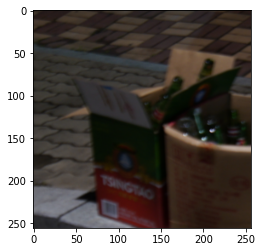

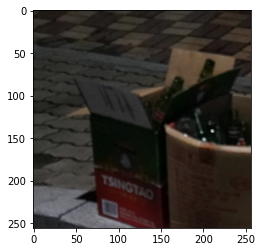

In [3]:
# PSNR sanity check
def show_image(idx: int):
    blur, gt = dataset[idx]
    print(calculate_psnr(tensor2uint(blur), tensor2uint(gt), input_order='HWC'))
    plt.imshow(tensor2uint(blur))
    plt.show()
    plt.imshow(tensor2uint(gt))
show_image(30)

In [5]:
a = torch.arange(64).reshape((8, 8)).unsqueeze(0)
a

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7],
         [ 8,  9, 10, 11, 12, 13, 14, 15],
         [16, 17, 18, 19, 20, 21, 22, 23],
         [24, 25, 26, 27, 28, 29, 30, 31],
         [32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47],
         [48, 49, 50, 51, 52, 53, 54, 55],
         [56, 57, 58, 59, 60, 61, 62, 63]]])

In [6]:
a.unfold(1, 2, 2).unfold(2, 2, 2).flatten(-2, -1).flatten(1, 2).shape

torch.Size([1, 16, 4])

In [15]:
window_size = 4
coords_h = torch.arange(window_size) # [0,...,Wh-1]
coords_w = torch.arange(window_size) # [0,...,Ww-1]
coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
coords_flatten = torch.flatten(coords, 1)
coords_flatten

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [16]:
bias_table = torch.arange((2 * window_size - 1) ** 2).unsqueeze(-1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
print(relative_coords.shape)
relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
relative_coords[:, :, 1] += window_size - 1
relative_coords[:, :, 0] *= 2 * window_size - 1
relative_position_index = relative_coords.sum(-1)
relative_coords.shape, relative_position_index.shape, torch.max(relative_position_index)

torch.Size([16, 16, 2])


(torch.Size([16, 16, 2]), torch.Size([16, 16]), tensor(48))

In [20]:
relative_position_bias = bias_table[relative_position_index.view(-1)].view(window_size ** 2, window_size ** 2, -1)
relative_position_bias = relative_position_bias.permute(2, 0, 1)
ratio = window_size ** 2 //relative_position_bias.size(-1)
print(relative_position_bias.shape)
relative_position_bias
# relative_position_bias = einops.repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
# print(relative_position_bias.shape, ratio)
relative_position_bias.shape, ratio

torch.Size([1, 16, 16])


(torch.Size([1, 16, 16]), 1)

In [94]:
print(bias_table.squeeze())

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14],
        [ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29],
        [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
          44],
        [ 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
          59],
        [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
          74],
        [ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
          89],
        [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
         104],
        [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
         119],
        [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
         134],
        [135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
         149],
        [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 1